In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from lesson_functions import *
import glob
import time

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_predict, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [4]:
def train_test_split_with_GTI(X, y, group_id, test_size, random_state):
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    
    for c_id in np.unique(group_id):
        X_group = X[group_id == c_id,:]
        y_group = y[group_id == c_id]
        if c_id ==0:
            # If this is KTTI data then, split it 
            X_train, X_test, y_train, y_test = train_test_split(
                X_group, y_group, test_size=0.2, random_state=0, stratify=y_group)
        else:         
            np.random.seed(c_id + random_state)
            test_index = np.mod(np.random.randint(0, X_group.shape[0]) + np.arange(0, int(X_group.shape[0] * test_size)),
                                 X_group.shape[0])
            train_index = list(set(range(0, X_group.shape[0])).difference(set(test_index)))
            X_train = X_group[train_index,:]
            X_test = X_group[test_index,:]
            y_train = y_group[train_index]
            y_test = y_group[test_index]
            
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)
    return np.concatenate(X_train_list, axis=0), np.concatenate(X_test_list, axis=0), np.concatenate(y_train_list), np.concatenate(y_test_list)

In [5]:
# create vehicle img list. We mark whether the data belongs to a certain GTI data directory.

vehicle_GTI_dirs = ['./data/vehicles/GTI_Far/', './data/vehicles/GTI_Left/', './data/vehicles/GTI_MiddleClose/', './data/vehicles/GTI_Right/']
vehicle_img_list = []
GTI_group_ids = []
cgroup_id = 1
for GTI_dir in vehicle_GTI_dirs:
    GTI_current_list = glob.glob(GTI_dir + '*.png')  
    vehicle_img_list = vehicle_img_list + GTI_current_list   
    GTI_group_ids = GTI_group_ids + [np.ones(len(GTI_current_list))*cgroup_id]
    cgroup_id += 1
KTTI_list = glob.glob('./data/vehicles/KITTI_extracted/*.png')
vehicle_img_list = vehicle_img_list+ KTTI_list
vehicle_group_id = np.concatenate(GTI_group_ids + [np.zeros(len(KTTI_list))])

# create non vehicle img list and group ids for non-vehicle data
non_vehicle_img_list = glob.glob('./data/non-vehicles/GTI/*.png') + glob.glob('./data/non-vehicles/Extras/*.png')
non_vehicle_group_id = np.zeros(len(non_vehicle_img_list))

# load all images
vehicle_images =  [cv2_readRGB(w) for w in vehicle_img_list]
non_vehicle_images =  [cv2_readRGB(w) for w in non_vehicle_img_list]
group_id = np.concatenate([vehicle_group_id, non_vehicle_group_id]).astype(int)

In [6]:
from sklearn.utils import shuffle
def obtain_fold_group(group_id,K):
    # divide data into K folds and return the fold index each sample belongs to
    test_fold_index = np.zeros_like(group_id)
    for c_id in np.unique(group_id):
        n_sample_in_group = np.sum(group_id == c_id)
        if c_id ==0:
            test_fold_index[group_id == c_id] = shuffle(np.floor_divide(np.arange(0, n_sample_in_group), np.ceil(n_sample_in_group/K)),random_state=0) 
        else:
            test_fold_index[group_id == c_id] = np.floor_divide(np.arange(0, n_sample_in_group), np.ceil(n_sample_in_group/K))
    return test_fold_index.astype(int)            

In [7]:
fold_indices = obtain_fold_group(group_id, 5)

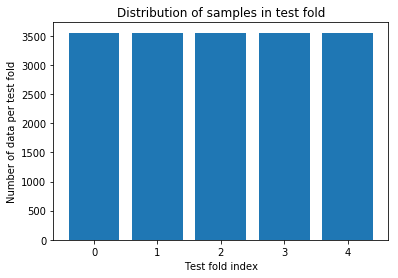

In [8]:
from scipy import stats
test_fold_dist = stats.itemfreq(fold_indices)
plt.bar(test_fold_dist[:,0], test_fold_dist[:,1])
plt.title('Distribution of samples in test fold')
plt.xlabel('Test fold index')
plt.ylabel('Number of data per test fold')
plt.savefig('./output_images/test_fold_distribution.png')

In [9]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = [0]# Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

# Compre HOG Features
There are multiple choices of parameters for calculating HOG Features, including color representation and color channel, number of pixels per cell, number of cell per block and number of orientations. 
The number of cell per blcok should be at least (2 x 2) to address the shadow / variation of lighting conditions. On the other hand, using (3x3) number cells per block would approximately double the number of features required for (2x2), requiring larger number of samples. We will initialize with (2x2) and also perform an experiment with 3x3 to see if there is any advantage. 
The number of pixels per cell should be chosen so that 1. there are enough data point to form a orientation "histogram"; 2. There are enough spatial resolution to recognize the object of interest:

## Number of pixels per cell
We start with 9 orientations, and try to vary the number of pixels per cell among 4x4, 8x8, 16x16, 32x32

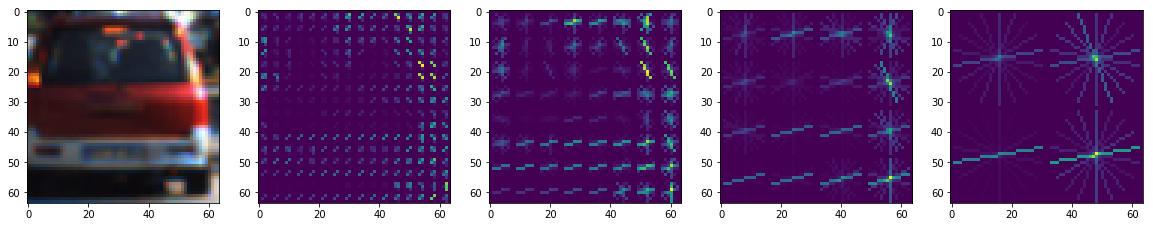

In [10]:
image_example = cv2_readRGB('./data/vehicles/KITTI_extracted/32.png')
plt.figure(figsize=(20,6))
plt.subplot(1,5,1)
plt.imshow(image_example)
jj=1
for p_per_cel in [4, 8,16,32]:
    jj += 1
    
    feature_example, hog_image_example = get_hog_features(cv2.cvtColor(image_example, cv2.COLOR_RGB2GRAY),
                                                          orient=orient, pix_per_cell=p_per_cel, 
                                                          cell_per_block=cell_per_block, 
                                                          vis=True)
    plt.subplot(1,5,jj)
    plt.imshow(hog_image_example)

A quick observation is that 32x32 is unliekly to be useful because the shape of the car is lost in aggregation. 
On the other hand, for 4x4, there are only 16 data points to compute what is essentially a histogram with 8 bins. This estimate of distribution would have a large standard deviation is that comparable to the expected mean, leading to a very noisy feature vector.

We will initialize the experiment with 8x8 pixels per cell and later experiment with 16x16. 

## Color Channels
We use the following setting and compare the performance of HOG features with linear SVM using different channels.
- orient = 9 # HOG orientations
- pix_per_cell = 8 # HOG pixels per cell
- cell_per_block = 2 # HOG cells per block

In [11]:
color_space_choice = ['RGB','HSV','LUV','HLS','YUV','YCrCb']
channel_choice = [[0],[1],[2],[0,1],[1,2],[0,2],[0,1,2]]

In [12]:
result = {}

for color_space in color_space_choice:
    for hog_channel in channel_choice:
        print((color_space, hog_channel))
        car_features = extract_features(vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        X_train_validate = scaled_X[fold_indices!=0,:]
        y_train_validate = y[fold_indices!=0]
        fold_train_validate = fold_indices[fold_indices!=0]        

        clf = LinearSVC()
        
        # 
        t=time.time()
        train_scores, test_scores = validation_curve(clf, X_train_validate, y_train_validate,
                                                     'C', np.array([1.0]),
                                                     cv= PredefinedSplit(fold_train_validate), n_jobs=4)
        #X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
        # Check the training time for the SVC                        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train classifier...')
        # Check the score of the SVC
        print('Train Accuracy of Classifier = ', round(np.mean(train_scores), 4))
        print('Test Accuracy of Classifier = ', round(np.mean(test_scores), 4))
        # Check the prediction time for a single sample
        result[(color_space, str(hog_channel))] = {'train': train_scores,
                                                   'test': test_scores,
                                                   'scaler': X_scaler}
result_l2 = result        

('RGB', [0])
10.76 Seconds to train classifier...
Train Accuracy of Classifier =  0.9998
Test Accuracy of Classifier =  0.9371
('RGB', [1])
9.06 Seconds to train classifier...
Train Accuracy of Classifier =  0.9998
Test Accuracy of Classifier =  0.9481
('RGB', [2])
8.56 Seconds to train classifier...
Train Accuracy of Classifier =  0.9996
Test Accuracy of Classifier =  0.9419
('RGB', [0, 1])
16.22 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9577
('RGB', [1, 2])
16.13 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9558
('RGB', [0, 2])
17.13 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9551
('RGB', [0, 1, 2])
24.69 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9647
('HSV', [0])
11.91 Seconds to train classifier...
Train Accuracy of Classifier =  0.999
Test Accuracy of Class

In [13]:
import pandas as pd
result_df_list = []
for key, val in result.items():
    result_df_list.append(pd.DataFrame({'train_accuracy': val['train'].mean(), 'train_std': val['train'].std(), 'test_accuracy': val['test'].mean(),
                                        'test_std': val['test'].std()}, index=[key]))
                 
    
result_df = pd.concat(result_df_list, axis=0)

In [14]:
result_df.sort_values('test_accuracy', ascending=False)

,test_accuracy,test_std,train_accuracy,train_std
"(LUV, [0, 1, 2])",0.985923,0.001988,1.000000,0.000000
"(YUV, [0, 1, 2])",0.985922,0.001473,1.000000,0.000000
"(YCrCb, [0, 1, 2])",0.985921,0.002271,1.000000,0.000000
"(YCrCb, [0, 1])",0.985570,0.000648,1.000000,0.000000
"(YUV, [0, 1])",0.985006,0.001738,1.000000,0.000000
"(HSV, [0, 1, 2])",0.984584,0.001209,1.000000,0.000000
"(HLS, [0, 1, 2])",0.984092,0.001274,1.000000,0.000000
"(LUV, [0, 1])",0.982474,0.001453,1.000000,0.000000
"(HLS, [0, 1])",0.980362,0.001337,1.000000,0.000000
"(HSV, [0, 2])",0.980291,0.001106,1.000000,0.000000


We observe that the top channels with best test accuracy is luminance Y in YUV/YCrCb color space. Other top results include L in LUV color space and V in HSV color space, of which both are closely related to Y, and RGB channels. We also observe that the other two channels in YUV / LUV has significantly worse performance. This all supports using Y channel for vehicle recognition. 

### HOGs features from Y Channel

In [ ]:
# define image examples
car_examples = [cv2_readRGB(w) for w in ['./data/vehicles/KITTI_extracted/32.png', './data/vehicles/KITTI_extracted/33.png', 
                                        './data/vehicles/KITTI_extracted/37.png', './data/vehicles/KITTI_extracted/125.png']]
noncar_examples = [cv2_readRGB(w) for w in ['./data/non-vehicles/GTI/image116.png', './data/non-vehicles/GTI/image306.png',
                                            './data/non-vehicles/GTI/image366.png', './data/non-vehicles/GTI/image440.png']]                                        

In [ ]:
f, axes = plt.subplots(4,8, sharex='row', figsize = (20,8))
jj = 0
for img in car_examples:
    img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0]
    car_features, car_hog_image = get_hog_features(img_channel,
                                                   orient=orient, pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block, 
                                                   vis=True)
    #plt.subplot(3, 8, jj)
    axes[0, jj].imshow(img)
    axes[1, jj].imshow(img_channel, 'gray')
    #plt.subplot(3, 8, jj+8)
    axes[2, jj].imshow(car_hog_image, 'gray')            
    axes[3, jj].barh(np.arange(0, len(car_features)), car_features)
    jj += 1


for img in noncar_examples:
    img_channel =  cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0]      
    noncar_features, noncar_hog_image = get_hog_features(img_channel,
                                                   orient=orient, pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block, 
                                                   vis=True)        
    #lt.subplot(3, 8, jj)
    axes[0, jj].imshow(img)
    axes[1, jj].imshow(img_channel, 'gray')
    #lt.subplot(3, 8, jj+8)
    axes[2, jj].imshow(noncar_hog_image, 'gray')            
    #lt.subplot(3, 8, jj+16)
    axes[3, jj].barh(np.arange(0, len(noncar_features)), noncar_features)
    jj += 1


## Pixels per cell of HOG

In [15]:
orient = 9  # HOG orientations
color_space = 'YUV' 
hog_channel = [0] # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

result = {}

for pix_per_cell in [8,16]:   
    for cell_per_block in [1, 2, 3]:
        print((pix_per_cell, cell_per_block))
        car_features = extract_features(vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        X_train_validate = scaled_X[fold_indices!=0,:]
        y_train_validate = y[fold_indices!=0]
        fold_train_validate = fold_indices[fold_indices!=0]        

        clf = LinearSVC()
        
        # 
        t=time.time()
        train_scores, test_scores = validation_curve(clf, X_train_validate, y_train_validate,
                                                     'C', np.array([1.0]),
                                                     cv= PredefinedSplit(fold_train_validate), n_jobs=5)
        #X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
        # Check the training time for the SVC                        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train classifier...')
        # Check the score of the SVC
        print('Train Accuracy of Classifier = ', round(np.mean(train_scores), 4))
        print('Test Accuracy of Classifier = ', round(np.mean(test_scores), 4))
        # Check the prediction time for a single sample
        result[(pix_per_cell, cell_per_block)] = {'train': train_scores,
                                              'test': test_scores,
                                              'scaler': X_scaler}


(8, 1)
6.17 Seconds to train classifier...
Train Accuracy of Classifier =  0.964
Test Accuracy of Classifier =  0.9426
(8, 2)
8.2 Seconds to train classifier...
Train Accuracy of Classifier =  0.9996
Test Accuracy of Classifier =  0.9463
(8, 3)
13.74 Seconds to train classifier...
Train Accuracy of Classifier =  0.9999
Test Accuracy of Classifier =  0.9512
(16, 1)
4.17 Seconds to train classifier...
Train Accuracy of Classifier =  0.9457
Test Accuracy of Classifier =  0.9393
(16, 2)
4.88 Seconds to train classifier...
Train Accuracy of Classifier =  0.9611
Test Accuracy of Classifier =  0.949
(16, 3)
5.57 Seconds to train classifier...
Train Accuracy of Classifier =  0.9576
Test Accuracy of Classifier =  0.9435


In [16]:
orient = 9  # HOG orientations
color_space = 'YCrCb' 
hog_channel = [0,1] # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

result = {}

for pix_per_cell in [8,16]:   
    for cell_per_block in [1, 2, 3]:
        print((pix_per_cell, cell_per_block))
        car_features = extract_features(vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        X_train_validate = scaled_X[fold_indices!=0,:]
        y_train_validate = y[fold_indices!=0]
        fold_train_validate = fold_indices[fold_indices!=0]        

        clf = LinearSVC()
        
        # 
        t=time.time()
        train_scores, test_scores = validation_curve(clf, X_train_validate, y_train_validate,
                                                     'C', np.array([1.0]),
                                                     cv= PredefinedSplit(fold_train_validate), n_jobs=5)
        #X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
        # Check the training time for the SVC                        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train classifier...')
        # Check the score of the SVC
        print('Train Accuracy of Classifier = ', round(np.mean(train_scores), 4))
        print('Test Accuracy of Classifier = ', round(np.mean(test_scores), 4))
        # Check the prediction time for a single sample
        result[(pix_per_cell, cell_per_block)] = {'train': train_scores,
                                              'test': test_scores,
                                              'scaler': X_scaler}


(8, 1)
3.6 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9786
(8, 2)
10.95 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9856
(8, 3)
17.59 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9849
(16, 1)
1.46 Seconds to train classifier...
Train Accuracy of Classifier =  0.9922
Test Accuracy of Classifier =  0.9785
(16, 2)
1.97 Seconds to train classifier...
Train Accuracy of Classifier =  0.9997
Test Accuracy of Classifier =  0.9787
(16, 3)
2.57 Seconds to train classifier...
Train Accuracy of Classifier =  0.999
Test Accuracy of Classifier =  0.9763
